In [9]:
# Imports
import os
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch
from numpy import log
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

In [95]:
# Define nn model
class Basic_CNN_MNISTClassifer(nn.Module):
    def __init__(self):
        super(Basic_CNN_MNISTClassifer, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 4*4 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.output = nn.LogSoftmax(dim=1)

    def forward(self, input):
        # Convolution layer C1: 1 input image channel, 6 output channels,
        # 5x5 square convolution, it uses RELU activation function, and
        # outputs a Tensor with size (N, 6, 28, 28), where N is the size of the batch
        c1 = F.relu(self.conv1(input))
        # Subsampling layer S2: 2x2 grid, purely functional,
        # this layer does not have any parameter, and outputs a (N, 6, 14, 14) Tensor
        s2 = F.max_pool2d(c1, (2, 2))
        # Convolution layer C3: 6 input channels, 16 output channels,
        # 5x5 square convolution, it uses RELU activation function, and
        # outputs a (N, 16, 10, 10) Tensor
        c3 = F.relu(self.conv2(s2))
        # Subsampling layer S4: 2x2 grid, purely functional,
        # this layer does not have any parameter, and outputs a (N, 16, 5, 5) Tensor
        s4 = F.max_pool2d(c3, 2)
        # Flatten operation: purely functional, outputs a (N, 400) Tensor
        s4 = torch.flatten(s4, 1)
        # Fully connected layer F5: (N, 400) Tensor input,
        # and outputs a (N, 120) Tensor, it uses RELU activation function
        f5 = F.relu(self.fc1(s4))
        # Fully connected layer F6: (N, 120) Tensor input,
        # and outputs a (N, 84) Tensor, it uses RELU activation function
        f6 = F.relu(self.fc2(f5))
        # Gaussian layer OUTPUT: (N, 84) Tensor input, and
        # outputs a (N, 10) Tensor
        output = self.fc3(f6)
        # Output layer
        output = self.output(output)
        return output

#### Model Source
https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

- Modified to accept single-channel 28x28 images instead of 3-channel 32x32
- Added final output layer of LogSoftMax to assign likelihood value to each category

In [3]:
# Load, transform, and split, and pre-cache data
# Load data
batch_size = 1000
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Training data
train_data = MNIST(os.getcwd(), train=True, download=True, transform=transform)
train_data, val_data = random_split(train_data, [0.9, 0.1])
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())
train_loader = [itm for itm in tqdm(train_loader)]
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())
val_loader = [itm for itm in tqdm(val_loader)]

# Testing data
test_data = MNIST(os.getcwd(), train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())
test_loader = [itm for itm in tqdm(test_loader)]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

tensor([1])


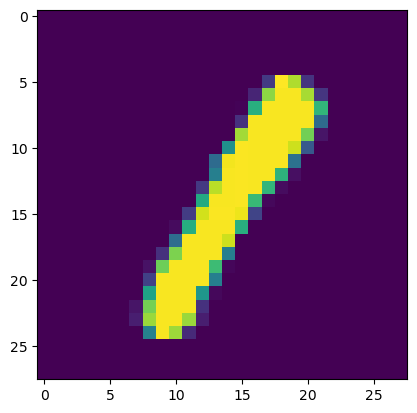

In [66]:
# Explore images returned by train dataloader iterator
# Each item returns list of two objects
# 1st object is tensor of batched images
# 2nd object is tensor of target labels
# batch tensor has shape of (batch_size, channels, width, height)
batch_index = torch.randint(len(test_loader), (1,))
batch_samples, batch_targets = test_loader[batch_index]
sample_index = torch.randint(len(batch_samples), (1,))
img_sample = batch_samples[sample_index].squeeze() # remove batch and channel dimensions
sample_target = batch_targets[sample_index]
plt.imshow(img_sample)
print(sample_target)

In [96]:
# Training and validation

# Loss and optimization selection
model = Basic_CNN_MNISTClassifer()
loss_fnc = torch.nn.functional.nll_loss
lr = 1e-2
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Training scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5)

# Move model to parallel GPU (all cores)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model= nn.DataParallel(model)
model = model.to(device)
# model = model.module.to(device)

# Set epoch number and track losses
num_epochs = 1000
train_losses = []
val_losses = []
lrs = [lr]
for epoch in tqdm(range(num_epochs)):

    # Training
    model.train()
    train_loss = 0
    for batch in train_loader:
        # Forward batch
        x, y = batch
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = loss_fnc(logits, y)
        train_loss += loss

        # Backprop and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    train_losses.append(train_loss/len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch in val_loader:
            # Forward batch
            x, y = batch
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = loss_fnc(logits, y)
            val_loss += loss

        # adjust the learning rate
        scheduler.step(loss)
        lrs.append(scheduler.get_last_lr()[0])
        val_losses.append(val_loss/len(val_loader))

    # Update progress
    # print(f'{epoch=}: {train_losses[-1]=}, {val_losses[-1]=}')
    print(f'Epoch: {epoch}: Training Loss: {train_losses[-1]:.3f}, Validation Loss: {val_losses[-1]:.3f}, Learing Rate: {lrs[-1]:.2E}')



  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0: Training Loss: 2.294, Validation Loss: 2.288, Learing Rate: 1.00E-02
Epoch: 1: Training Loss: 2.279, Validation Loss: 2.269, Learing Rate: 1.00E-02
Epoch: 2: Training Loss: 2.256, Validation Loss: 2.237, Learing Rate: 1.00E-02
Epoch: 3: Training Loss: 2.207, Validation Loss: 2.162, Learing Rate: 1.00E-02
Epoch: 4: Training Loss: 2.066, Validation Loss: 1.906, Learing Rate: 1.00E-02
Epoch: 5: Training Loss: 1.585, Validation Loss: 1.178, Learing Rate: 1.00E-02
Epoch: 6: Training Loss: 0.885, Validation Loss: 0.659, Learing Rate: 1.00E-02
Epoch: 7: Training Loss: 0.591, Validation Loss: 0.509, Learing Rate: 1.00E-02
Epoch: 8: Training Loss: 0.495, Validation Loss: 0.442, Learing Rate: 1.00E-02
Epoch: 9: Training Loss: 0.433, Validation Loss: 0.399, Learing Rate: 1.00E-02
Epoch: 10: Training Loss: 0.395, Validation Loss: 0.368, Learing Rate: 1.00E-02
Epoch: 11: Training Loss: 0.366, Validation Loss: 0.343, Learing Rate: 1.00E-02
Epoch: 12: Training Loss: 0.343, Validation Loss: 

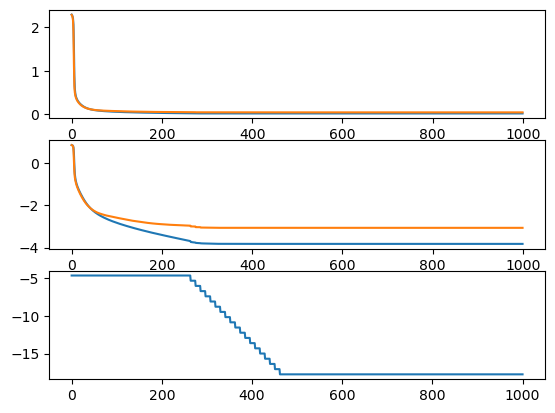

In [97]:
# Evaluate training and validation loss curves
train_losses = [loss.to('cpu').detach() for loss in train_losses]
val_losses = [loss.to('cpu').detach() for loss in val_losses]
plt.subplot(3,1,1)
plt.plot(range(len(train_losses)), [loss for loss in train_losses])
plt.plot(range(len(val_losses)), [loss for loss in val_losses])
plt.subplot(3,1,2)
plt.plot(range(len(train_losses)), [torch.log(loss) for loss in train_losses])
plt.plot(range(len(val_losses)), [torch.log(loss) for loss in val_losses])
plt.subplot(3,1,3)
plt.plot(range(len(lrs)), [log(lr) for lr in lrs])

In [98]:
# Perform inference on the test dataset
samples, targets, predictions = [], [], []
for batch_samples, batch_targets in tqdm(test_loader):
    samples += [sample.squeeze() for sample in batch_samples]
    targets += batch_targets.tolist()

    model.to('cpu')
    for sample, target in zip(batch_samples, batch_targets):
        sample = sample.unsqueeze(dim=0)
        output = model(sample)
        output = torch.exp(output)
        prediction = torch.argmax(output)
        # target = target.item()
        predictions.append(prediction)

# Calculate accuracy
accuracy = sum([target == prediction for target, prediction in zip(targets, predictions)])/len(targets)*100
print(f'Accuracy: {accuracy.item():.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy: 98.85%


Prediction = 7, target = 7, confidence = 58.65%
Top 3: [7, 2, 3]


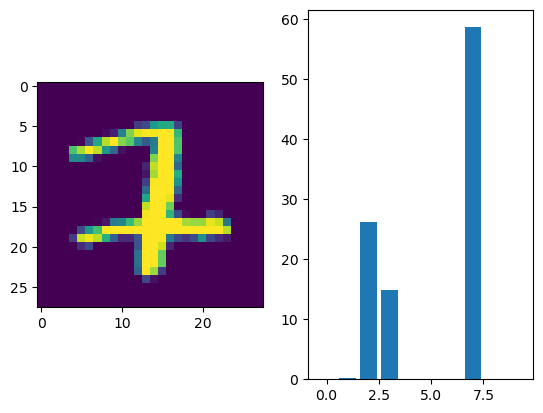

In [117]:
# Explore some example predictions from the test set
# Search for low confidence predictions by setting <threshold_confidence>
max_iters, curr_iters = 500, 0
while True:
    threshold_confidence = 60
    batch_index = torch.randint(len(test_loader), (1,))
    batch_samples, batch_targets = test_loader[batch_index]
    sample_index = torch.randint(len(batch_samples), (1,))
    img_sample = batch_samples[sample_index].squeeze()
    sample_target = batch_targets[sample_index]
    img_sample = img_sample
    output = model(img_sample.unsqueeze(dim=0).unsqueeze(dim=0))
    top3 = torch.argsort(output, descending=True).squeeze()[:3].tolist()
    prediction = top3[0]
    confidence = torch.max(torch.exp(output)).item()*100
    curr_iters += 1
    if confidence < threshold_confidence:
        print(f'Prediction = {prediction}, target = {sample_target.item()}, confidence = {confidence:.2f}%')
        print(f'Top 3: {top3}')
        plt.subplot(1,2, 1)
        plt.imshow(img_sample)
        plt.subplot(1,2,2)
        plt.bar(torch.arange(len(output.squeeze())), torch.exp(output.squeeze()).detach()*100)
        break
    elif curr_iters < max_iters:
        continue
    else:
        break

#### Results
- After model definition changes, no changes required for the training and evaluation stages
- Accuracy of 98.85% on the test set
- Low confidence predictions are much harder to find
    - Max iterations on search increased from 100 to 500